# **Air Quality Data Retrieval and Processing**
### - COMP5339 Project Assignment Stage 1

    Author: Shiwen Xu 

    SID: 520569045 

    UniKey: shxu4542

    Date: April 7, 2024

## Load Packages

In [1]:
import os
import sys
import requests, json
import pandas as pd 
import numpy as np
import logging 
import urllib
import datetime as dt
import matplotlib.pyplot as plt 
import seaborn as sns
import psycopg2
import csv

## Data Retrieval

### Helper functions

In [2]:
"""
This code is modified from https://www.environment.nsw.gov.au/-/media/OEH/Corporate-Site/Documents/Air/air-quality-application-programming-interface-user-guide-210346.pdf
"""
class aqms_api_class(object):
    """
    This class defines and configures the API to query the Azure DataWarehouse 
    """
    def __init__(self, type):
        self.logger = logging.getLogger(type)
        self.url_api = "https://data.airquality.nsw.gov.au"
        self.headers = {'content-type': 'application/json', 'accept':'application/json'}
        self.type = type
        if self.type == 'site':
            self.type_url = '/api/Data/get_SiteDetails'
        elif self.type == 'param':
            self.type_url = 'api/Data/get_ParameterDetails'
        elif self.type == 'observ':
            self.type_url = 'api/Data/get_Observations'
        else:
            raise ValueError("Incorrect Data Type")
    
    def get_details(self, ):
        """
        Build a query to return all the details
        """
        query = urllib.parse.urljoin(self.url_api, self.type_url)
        response = requests.get(url=query, data='')
        return response
    
    
    def post_details(self, ObsRequest=None):
        """ 
        Build a query to extract current hourly observed 
        """
        assert self.type == 'observ'

        # retrieve current hourly observed air quality data by default
        query = urllib.parse.urljoin(self.url_api, self.type_url)
        if ObsRequest:
            response = requests.post(url=query, data=json.dumps(ObsRequest), headers=self.headers)
        else:
            response = requests.post(url=query, data='', headers=self.headers)
        return response
    

    def ObsRequest_init(self, 
                        parameters:list, 
                        sites:list, 
                        startdate:dt, 
                        enddate:dt, 
                        categories:list, 
                        subcategories:list):
        """ 
        Build a query to extract historical air quality data by pre-defined criteria
        :param parameters: e.g ['OZONE']
        :param sites: e.g [190, 221]
        :param startdate: e.g dt.Date(2018, 12, 1)
        :param enddate: e.g dt.Date(2019, 12, 1)
        :param categories: e.g ['Maximums']
        :param categories: e.g ['Daily']
        :param categories: e.g ['4h rolling average derived from 1h average']
        """
        ObsRequest = {}
        ObsRequest['Parameters'] = parameters
        ObsRequest['Sites'] = sites
        ObsRequest['StartDate'] = startdate.strftime('%Y-%m-%d')
        ObsRequest['EndDate'] = enddate.strftime('%Y-%m-%d')
        ObsRequest['Categories'] = categories
        ObsRequest['SubCategories'] = subcategories

        return ObsRequest


### Site 
Monitoring site data including the site name, longitude, latitude and region. 

(url = “https://data.airquality.nsw.gov.au/api/Data/get_SiteDetails”)

In [3]:
"""
Save Site Details to a json file and Create the Site dataframe
"""
AQMS_S = aqms_api_class(type='site')
AllSites = AQMS_S.get_details()
site_data = json.loads(AllSites.text)
with open('site.json', 'w', encoding='utf-8') as f_site:
    json.dump(site_data, f_site)
site_df = pd.DataFrame(site_data)
site_df.shape

(134, 5)

### Parameters
Details the air pollutants and meteorological parameters, monitored by the DPIE including parameter averaging periods and exceedances

(url = "https://data.airquality.nsw.gov.au/api/Data/get_ParameterDetails”)

In [4]:
"""
Save Parameter Details to a json file and Create the Parameter dataframe
"""
AQMS_P = aqms_api_class(type='param')
AllParams = AQMS_P.get_details()
param_data = json.loads(AllParams.text)
with open('param.json', 'w', encoding='utf-8') as f_param:
    json.dump(param_data, f_param)
param_df = pd.DataFrame(param_data)
param_df.shape

(136, 7)

### Observations
Air quality and meteorological observational data collected from the air quality monitoring network, can be searched and downloaded as current real-time hourly data or as historical data. Current observational data is refreshed every hour. 

(url = “https://data.airquality.nsw.gov.au/api/Data/get_Observations”)


Air Quality
* Gas 
* Particles 
* Meterological

In this study, we aim to examine the average monthly `OZONE` data from `Sydney` adjacent regions from past 5 years.

In [5]:
"""
Save Observation Details to a json file and Create the Observation dataframe
"""

parameters = ['OZONE']
regions = ['Sydney East', 'Sydney South-west', 'Sydney North-West', 'Sydney north-west', 'Sydney south-west'] 
sites = site_df.loc[site_df['Region'].isin(regions), 'Site_Id'].tolist() # Find out all regions_id in Sydney East Region
startDate = dt.date(2019, 1, 1)
endDate = dt.date(2023, 12, 31)  
categories = ['Averages']
SubCategories = ['Monthly']

AQMS_O = aqms_api_class(type='observ')
ObsRequest = AQMS_O.ObsRequest_init(parameters, sites, startDate, endDate, categories, SubCategories)
Ozone_Obs = AQMS_O.post_details(ObsRequest)

ozone_obs_data = json.loads(Ozone_Obs.text)
with open('observs.json', 'w', encoding='utf-8') as f_obs:
    json.dump(ozone_obs_data, f_obs)
obs_df = pd.DataFrame(ozone_obs_data)
obs_df.shape


(1534, 8)

## Data Cleaning

For each obtained dataframes, this data cleaning process will examine the following: 
- Missing values 
- Duplicate records 
- Column types
- Column values 

### Missing Values

In [6]:
""" 
A helper function to check missing values in the dataframe
"""
def count_missing(dataframe, name):
    flag = 0
    for col in dataframe.columns:
        missing = dataframe[col].isnull().sum()
        if missing > 0:
            flag = 1
            dataframe.loc[dataframe[col].isnull(), col] = np.NaN# fillna with empty string so that it can write to database
            print(f'Dataframe {name}: {col} contains {missing} missing values.')
    if flag == 0:
        print(f'Dataframe {name}: No Missing Values Found.')

In [7]:
"""
Site Dataframe
"""
## 1. site_df overview 
print(site_df.shape)
print(site_df.columns)

## 2. Check Missing Values 
count_missing(site_df, "SITE")

## 3. print the SiteNames for missing Longitude & Latitude 
print(site_df[site_df['Longitude'].isna()]['SiteName'])

## 4. find which region has the most missing locations
missing_loc_df = site_df.loc[site_df.isna().any(axis=1)]
missing_locations_by_region = missing_loc_df.groupby('Region').size()
region_with_most_missing = missing_locations_by_region.idxmax()
max_missing_count = missing_locations_by_region.max()
print("Region with the most missing location sites:")
print("Region:", region_with_most_missing)
print("Number of missing locations:", max_missing_count)

(134, 5)
Index(['Site_Id', 'SiteName', 'Longitude', 'Latitude', 'Region'], dtype='object')
Dataframe SITE: Longitude contains 17 missing values.
Dataframe SITE: Latitude contains 17 missing values.
107                  Central Coast
108             Central Tablelands
109                      Illawarra
110                 Lake Macquarie
111                   Lower Hunter
112                        Merriwa
113                Mid-north Coast
114              North-west slopes
115            Northern Tablelands
116              South-west slopes
117            Southern Tablelands
118              Sydney north-west
119              Sydney south-west
120    Upper Hunter - Muswellbrook
121       Upper Hunter - Singleton
122    Upper Hunter - Muswellbrook
129       Upper Hunter - Singleton
Name: SiteName, dtype: object
Region with the most missing location sites:
Region: Upper Hunter - Muswellbrook
Number of missing locations: 2


In [8]:
# replace missingness with -999 for longitude & latitude 
site_df['Longitude'] = site_df['Longitude'].fillna(-999)
site_df['Latitude'] = site_df['Latitude'].fillna(-999)

In [9]:
"""
Parameter Dataframe
"""
## 1. param_df overview 
print(param_df.shape)
print(param_df.columns)

## 2. Check Missing Values 
count_missing(param_df, "PARAM")

(136, 7)
Index(['ParameterCode', 'ParameterDescription', 'Units', 'UnitsDescription',
       'Category', 'SubCategory', 'Frequency'],
      dtype='object')
Dataframe PARAM: No Missing Values Found.


In [10]:
""" 
Observation Dataframe
"""
## 1. param_df overview 
print(obs_df.shape)
print(obs_df.columns)

## 2. Check Missing Values 
count_missing(obs_df, "OBS")

## 3. Examine Missing Value Patterns
# 3.1 Check Site_Id 
miss_val_siteIds = obs_df.loc[obs_df['Value'].isna(), 'Site_Id'].unique().tolist()
print("Missing Value Site_Ids: ", miss_val_siteIds)

## 4. Drop Irrelevant columns 
obs_df.drop(['AirQualityCategory'], axis=1, inplace=True)
obs_df.drop(['DeterminingPollutant'], axis=1, inplace=True)

(1534, 8)
Index(['Site_Id', 'Parameter', 'Date', 'Hour', 'HourDescription', 'Value',
       'AirQualityCategory', 'DeterminingPollutant'],
      dtype='object')
Dataframe OBS: Value contains 409 missing values.
Dataframe OBS: AirQualityCategory contains 1534 missing values.
Dataframe OBS: DeterminingPollutant contains 1534 missing values.
Missing Value Site_Ids:  [15, 1001, 1141, 33, 39, 107, 113, 171, 206, 574, 1570, 2560, 2570]


In [11]:
# fill missing value with -999 
obs_df['Value'] = obs_df['Value'].fillna(-999)
obs_df.shape

(1534, 6)

### Duplicate Rows

In [12]:
## check duplicate rows for Site Dataframe
print(site_df[site_df.duplicated()])

## check duplicate rows for Params Dataframe 
print(param_df[param_df.duplicated()])

Empty DataFrame
Columns: [Site_Id, SiteName, Longitude, Latitude, Region]
Index: []
Empty DataFrame
Columns: [ParameterCode, ParameterDescription, Units, UnitsDescription, Category, SubCategory, Frequency]
Index: []


### Data Types

In [13]:
""" 
Site Dataframe
"""
print("==== Original dtypes ====")
print(site_df.dtypes)
site_df['SiteName'] = site_df['SiteName'].astype('category') # convert sitename to category type
site_df['Region'] = site_df['Region'].astype('category') # convert sitename to category type
print("==== Converted dtypes ====")
print(site_df.dtypes)

==== Original dtypes ====
Site_Id        int64
SiteName      object
Longitude    float64
Latitude     float64
Region        object
dtype: object
==== Converted dtypes ====
Site_Id         int64
SiteName     category
Longitude     float64
Latitude      float64
Region       category
dtype: object


In [14]:
""" 
Parameter Dataframe 
"""
print("==== Original dtypes ====")
print(param_df.dtypes)
param_df['ParameterCode'] = param_df['ParameterCode'].astype('category') # convert ParameterCode to category type
param_df['ParameterDescription'] = param_df['ParameterDescription'].astype('string') # convert ParameterDescription to string type
param_df['Units'] = param_df['Units'].astype('category') # convert Units to category type
param_df['UnitsDescription'] = param_df['UnitsDescription'].astype('string') # convert UnitsDescription to string type
param_df['Category'] = param_df['Category'].astype('category') # convert Category to category type
param_df['SubCategory'] = param_df['SubCategory'].astype('category') # convert SubCategory to category type
param_df['Frequency'] = param_df['Frequency'].astype('category') # convert Frequency to category type
print("==== Converted dtypes ====")
print(param_df.dtypes)

==== Original dtypes ====
ParameterCode           object
ParameterDescription    object
Units                   object
UnitsDescription        object
Category                object
SubCategory             object
Frequency               object
dtype: object
==== Converted dtypes ====
ParameterCode           category
ParameterDescription      string
Units                   category
UnitsDescription          string
Category                category
SubCategory             category
Frequency               category
dtype: object


### Data Values

In [15]:
""" 
Site Dataframe
"""
## 1. Categorical Data 
print(site_df['Region'].unique().tolist())
# found 'Sydney South-west' & 'Sydney south-west' 
# found 'Sydney North-west' & 'Sydney north-west' 
# check if these two contains the same sites 
print("Site_Id in Sydney South-west Region")
print(site_df.loc[site_df['Region'] == 'Sydney South-west', 'Site_Id'].unique().tolist())
print("Site_Id in Sydney south-west Region")
print(site_df.loc[site_df['Region'] == 'Sydney south-west', 'Site_Id'].unique().tolist())

print("Site_Id in Sydney North-west Region")
print(site_df.loc[site_df['Region'] == 'Sydney North-west', 'Site_Id'].unique().tolist())
print("Site_Id in Sydney north-west Region")
print(site_df.loc[site_df['Region'] == 'Sydney north-west', 'Site_Id'].unique().tolist())
# NOTE Region contains different site_ids. No further cleaning steps are needed. 


['Sydney East', 'Sydney South-west', 'Central Coast', 'Lower Hunter', 'Newcastle Local', 'North-west Slopes', 'Illawarra', 'Sydney North-west', 'South-west Slopes', 'Central Tablelands', 'Port Kembla Steelworks', 'Upper Hunter', 'Cataract RFS', 'Research Monitoring ', 'Western LLS', 'Central West LLS', 'Central Tablelands LLS', 'Murray LLS', 'Riverina LLS', 'North West LLS', 'SA Murray Darling Basin', 'North Central CMA', 'SA Arid Lands', 'Mallee CMA', 'Northern Tablelands', 'Incident Monitoring', 'Mid-North Coast', 'Northern Tablelands LLS', 'Roadside Monitoring', 'Southern Tablelands', 'North Coast LLS', 'Bushfire Monitoring', 'Bushfire - Lismore (offline)', 'South East LLS', 'Lake Macquarie', 'Merriwa', 'Mid-north Coast', 'North-west slopes', 'South-west slopes', 'Sydney north-west', 'Sydney south-west', 'Upper Hunter - Muswellbrook', 'Upper Hunter - Singleton', 'Test Region', 'Cadia Monitoring', 'Cadia Monitoring DRX']
Site_Id in Sydney South-west Region
[107, 171, 574, 1560, 1570,

In [16]:
## 2. Numeric Data 
complete_site_df = site_df.loc[(site_df['Longitude'] != -999) & (site_df['Latitude'] != -999)]
print(complete_site_df['Longitude'].describe())
print(complete_site_df['Latitude'].describe())

count    117.000000
mean     149.085173
std        3.271016
min      139.737000
25%      147.360846
50%      150.703850
75%      151.117800
max      153.293502
Name: Longitude, dtype: float64
count    117.000000
mean     -33.236795
std        1.684103
min      -36.907750
25%      -34.244788
50%      -33.682750
75%      -32.472310
max      -28.832130
Name: Latitude, dtype: float64


In [17]:
""" 
Parameter Dataframe
"""
## 1. Categorical Data 
print(param_df['Units'].unique().tolist())
print(param_df['Category'].unique().tolist())
print(param_df['SubCategory'].unique().tolist())
print(param_df['Frequency'].unique().tolist())

['category', 'count', 'ppm', '%', '10^-4 m^-1', 'pphm', 'µg/m³', 'mm/m²', '°', 'W/m²', '°C', 'm/s']
['Site AQC', 'Exceedences', 'Averages', 'Maximums', 'Regional AQC']
['Daily', 'Hourly', 'Annual', 'Monthly', 'Yearly']
['Hourly average', '8h rolling average derived from 1h average', '24h average derived from 1h average', '4h rolling average derived from 1h average', '24h rolling average derived from 1h average']


In [18]:
## 2. Categorical data decription
print(param_df['Units'].describe())
print(param_df['Category'].describe())
print(param_df['SubCategory'].describe())
print(param_df['Frequency'].describe())

count      136
unique      12
top       pphm
freq        41
Name: Units, dtype: object
count          136
unique           5
top       Averages
freq            58
Name: Category, dtype: object
count        136
unique         5
top       Annual
freq          37
Name: SubCategory, dtype: object
count                136
unique                 5
top       Hourly average
freq                  90
Name: Frequency, dtype: object


In [19]:
"""
Observation Dataframe
"""
## 3. Numeric Data 
complete_obs_df = obs_df[obs_df['Value'] != -999] # filter out empty value
print(complete_obs_df['Value'].describe())

count    1125.000000
mean        1.688309
std         0.486996
min         0.605529
25%         1.326392
50%         1.669644
75%         1.967556
max         3.446455
Name: Value, dtype: float64


## Data Transformation

In [20]:
# NOTE no further transformation needed for site_df and params_df
## Transform the Observation Dataframe 
obs_df = pd.concat([obs_df, pd.json_normalize(obs_df['Parameter'])], axis=1)
obs_df.drop(columns=['Parameter'], inplace=True)
obs_df.head(3)

,Site_Id,Date,Hour,HourDescription,Value,ParameterCode,ParameterDescription,Units,UnitsDescription,Category,SubCategory,Frequency
0,15,2019-01-31,1,12 am - 1 am,-999.000000,OZONE,Ozone,pphm,parts per hundred million,Averages,Monthly,4h rolling average derived from 1h average
1,15,2019-01-31,1,12 am - 1 am,-999.000000,OZONE,Ozone,pphm,parts per hundred million,Averages,Monthly,Hourly average
2,33,2019-01-31,1,12 am - 1 am,2.210982,OZONE,Ozone,pphm,parts per hundred million,Averages,Monthly,4h rolling average derived from 1h average


In [21]:
""" 
Observation Dataframe 
"""
print("==== Original dtypes ====")
print(obs_df.dtypes)
# NOTE Parameter remains object type. After transformation, will convert to category types
obs_df['Date'] = pd.to_datetime(obs_df['Date']) # convert date to Date type 
obs_df['HourDescription'] = obs_df['HourDescription'].astype('string') # convert HourDescription to string type
obs_df['ParameterCode'] = obs_df['ParameterCode'].astype('category') # convert ParameterCode to category type
obs_df['ParameterDescription'] = obs_df['ParameterDescription'].astype('string') # convert ParameterCode to category type
obs_df['Units'] = obs_df['Units'].astype('string') # convert ParameterCode to category type
obs_df['UnitsDescription'] = obs_df['UnitsDescription'].astype('string') # convert ParameterCode to category type
obs_df['Category'] = obs_df['Category'].astype('category') # convert Category to category type
obs_df['SubCategory'] = obs_df['SubCategory'].astype('category') # convert Category to category type
obs_df['Frequency'] = obs_df['Frequency'].astype('category') # convert Category to category type
print("==== Converted dtypes ====")
print(obs_df.dtypes)

==== Original dtypes ====
Site_Id                   int64
Date                     object
Hour                      int64
HourDescription          object
Value                   float64
ParameterCode            object
ParameterDescription     object
Units                    object
UnitsDescription         object
Category                 object
SubCategory              object
Frequency                object
dtype: object
==== Converted dtypes ====
Site_Id                          int64
Date                    datetime64[ns]
Hour                             int64
HourDescription                 string
Value                          float64
ParameterCode                 category
ParameterDescription            string
Units                           string
UnitsDescription                string
Category                      category
SubCategory                   category
Frequency                     category
dtype: object


## Save Data 

### Save to CSV

In [22]:
site_df.to_csv('site.csv', index=False)
param_df.to_csv('param.csv', index=False)
obs_df.to_csv('obs.csv', index=False)

### Helper Functions

In [23]:
"""Modified from COMP5310 week 4 tutorial slides"""


def pgconnect(dbname='postgres'):
    """ 
    utility function to connect to Postgresql database
    """
    YOUR_DBNAME = f'{dbname}'
    YOUR_USERNAME = 'postgres'
    YOUR_PW     = '2020352!'
    PORT = "2024"
    try: 
        conn = psycopg2.connect(host='localhost',
                                port = PORT,
                                database=YOUR_DBNAME,
                                user=YOUR_USERNAME, 
                                password=YOUR_PW)
        print('connected')
    except Exception as e:
        print("unable to connect to the database")
        print(e)
    return conn


def pgexec( conn, sqlcmd, args, msg, silent=False ):
   """ 
   utility function to execute some SQL statement can take optional arguments to fill in (dictionary) error and transaction handling built-in 
   """
   retval = False
   with conn:
      with conn.cursor() as cur:
         try:
            if args is None:
               cur.execute(sqlcmd)
            else:
               cur.execute(sqlcmd, args)
            if silent == False: 
                print("success: " + msg)
            retval = True
         except Exception as e:
            if silent == False: 
                print("db error: ")
                print(e)
   conn.commit()
   return retval


def pgquery( conn, sqlcmd, args, silent=False ):
   """ utility function to execute some SQL query statement
       can take optional arguments to fill in (dictionary)
       will print out on screen the result set of the query
       error and transaction handling built-in """
   retval = False
   res = []
   with conn:
      with conn.cursor() as cur:
         try:
            if args is None:
                print("sqlcmd: ", sqlcmd)
                cur.execute(sqlcmd)
            else:
                cur.execute(sqlcmd, args)
            if silent == False:
                for record in cur:
                    print(record)
                    res.append(record)
            retval = True
         except Exception as e:
            if silent == False:
                print("db read error: ")
                print(e)
   return retval, res

### Save to Postgres

In [43]:
""" 
Write to tables using site dataframe 
(1) region 
(2) site
"""
# 1. get data 
reg_list = site_df.Region.unique().tolist()
region_df = pd.DataFrame(reg_list, columns=['region'])
region_df.to_csv('region.csv', index=False)
data_region = list(csv.DictReader(open('region.csv')))
data_site = list(csv.DictReader(open('site.csv')))

# 2 write to database
# 2.1 connect to database 
conn = pgconnect(dbname='air_quality')
# 2.2 create region table & write data to it
pgexec (conn, "DROP TABLE IF EXISTS Region CASCADE", None, "Reset Table Region")
region_schema = """CREATE TABLE IF NOT EXISTS Region (
                         region VARCHAR(30) PRIMARY KEY NOT NULL
                   )"""
pgexec (conn, region_schema, None, "Create Table Region")
insert_stmt = """INSERT INTO Region(region) VALUES (%(region)s)"""
for i, row in enumerate(data_region):
    pgexec (conn, insert_stmt, row, f"Row {i+1} inserted")

# 2.3 create site table & write data to it 
pgexec (conn, "DROP TABLE IF EXISTS Site CASCADE", None, "Reset Table Site")
site_schema = """CREATE TABLE IF NOT EXISTS Site (
                         site_id INTEGER PRIMARY KEY NOT NULL,
                         site_name VARCHAR(30) NOT NULL,
                         longitude FLOAT, 
                         latitude FLOAT, 
                         region VARCHAR(30),
                         CONSTRAINT regionFK FOREIGN KEY (region)   REFERENCES Region (region)
                   )"""
pgexec (conn, site_schema, None, "Create Table Site")
insert_stmt = """INSERT INTO Site(site_id, site_name, longitude, latitude, region) VALUES (%(Site_Id)s, %(SiteName)s, %(Longitude)s, %(Latitude)s, %(Region)s)"""
for i, row in enumerate(data_site):
    pgexec (conn, insert_stmt, row, f"Row {i+1} inserted")

connected
success: Reset Table Region
success: Create Table Region
success: Row 1 inserted
success: Row 2 inserted
success: Row 3 inserted
success: Row 4 inserted
success: Row 5 inserted
success: Row 6 inserted
success: Row 7 inserted
success: Row 8 inserted
success: Row 9 inserted
success: Row 10 inserted
success: Row 11 inserted
success: Row 12 inserted
success: Row 13 inserted
success: Row 14 inserted
success: Row 15 inserted
success: Row 16 inserted
success: Row 17 inserted
success: Row 18 inserted
success: Row 19 inserted
success: Row 20 inserted
success: Row 21 inserted
success: Row 22 inserted
success: Row 23 inserted
success: Row 24 inserted
success: Row 25 inserted
success: Row 26 inserted
success: Row 27 inserted
success: Row 28 inserted
success: Row 29 inserted
success: Row 30 inserted
success: Row 31 inserted
success: Row 32 inserted
success: Row 33 inserted
success: Row 34 inserted
success: Row 35 inserted
success: Row 36 inserted
success: Row 37 inserted
success: Row 38 i

In [169]:
""" 
Write to tables using parameter dataframe 
(1) type 
(2) category
(3) unit 
(4) subcategory 
(5) frequency 
(6) parameter
"""
## 1. get data 
# get type data 
type_df = param_df[['ParameterCode', 'ParameterDescription']].drop_duplicates()
type_df.to_csv('type.csv', index=False)
# get unit data 
unit_df = param_df[['Units', 'UnitsDescription']].drop_duplicates()
unit_df.to_csv('unit.csv', index=False)
# get category data 
uniq_list = param_df.Category.unique().tolist()
category_df = pd.DataFrame(uniq_list,  columns=['Category'])
category_df.to_csv('category.csv', index=False)
# get subcategory data 
uniq_list = param_df.SubCategory.unique().tolist()
subca_df = pd.DataFrame(uniq_list, columns=['Subcategory'])
subca_df.to_csv('subcategory.csv', index=False)
# get frequency data 
uniq_list = param_df.Frequency.unique().tolist()
freq_df = pd.DataFrame(uniq_list, columns=['Frequency'])
freq_df.to_csv('frequency.csv', index=False)

## 2. read data
data_type = list(csv.DictReader(open('type.csv')))
data_unit = list(csv.DictReader(open('unit.csv')))
data_cate = list(csv.DictReader(open('category.csv')))
data_subcate = list(csv.DictReader(open('subcategory.csv')))
data_freq = list(csv.DictReader(open('frequency.csv')))
data_param = list(csv.DictReader(open('param.csv')))

## 3. connect to pg 
conn = pgconnect(dbname='air_quality')


# write type data
pgexec (conn, "DROP TABLE IF EXISTS Type CASCADE", None, "Reset Table Type")
type_schema = """CREATE TABLE IF NOT EXISTS Type (
                         parameter_code VARCHAR(30) PRIMARY KEY NOT NULL, 
                         parameter_description VARCHAR(50)
                   )"""
pgexec (conn, type_schema, None, "Create Table Type")
insert_stmt = """INSERT INTO Type(parameter_code, parameter_description) VALUES (%(ParameterCode)s, %(ParameterDescription)s)"""
for i, row in enumerate(data_type):
    pgexec (conn, insert_stmt, row, f"Row {i+1} inserted")

# write unit data
pgexec (conn, "DROP TABLE IF EXISTS Unit CASCADE", None, "Reset Table Unit")
unit_schema = """CREATE TABLE IF NOT EXISTS Unit (
                         unit VARCHAR(20) PRIMARY KEY NOT NULL, 
                         unit_description VARCHAR(30)
                   )"""
pgexec (conn, unit_schema, None, "Create Table Unit")
insert_stmt = """INSERT INTO Unit(unit, unit_description) VALUES (%(Units)s, %(UnitsDescription)s)"""
for i, row in enumerate(data_unit):
    pgexec (conn, insert_stmt, row, f"Row {i+1} inserted")


# write category data
pgexec (conn, "DROP TABLE IF EXISTS Category CASCADE", None, "Reset Table Category")
cate_schema = """CREATE TABLE IF NOT EXISTS Category (
                         category VARCHAR(20) PRIMARY KEY NOT NULL
                   )"""
pgexec (conn, cate_schema, None, "Create Table Category")
insert_stmt = """INSERT INTO Category(category) VALUES (%(Category)s)"""
for i, row in enumerate(data_cate):
    pgexec (conn, insert_stmt, row, f"Row {i+1} inserted")


# write subcategory data
pgexec (conn, "DROP TABLE IF EXISTS Subcategory CASCADE", None, "Reset Table Subcategory")
subcate_schema = """CREATE TABLE IF NOT EXISTS Subcategory (
                         subcategory VARCHAR(10) PRIMARY KEY NOT NULL
                   )"""
pgexec (conn, subcate_schema, None, "Create Table Subcategory")
insert_stmt = """INSERT INTO Subcategory(subcategory) VALUES (%(Subcategory)s)"""
for i, row in enumerate(data_subcate):
    pgexec (conn, insert_stmt, row, f"Row {i+1} inserted")


# write frequency data
pgexec (conn, "DROP TABLE IF EXISTS Frequency CASCADE", None, "Reset Table Frequency")
freq_schema = """CREATE TABLE IF NOT EXISTS Frequency (
                         frequency VARCHAR(50) PRIMARY KEY NOT NULL
                   )"""
pgexec (conn, freq_schema, None, "Create Table Frequency")
insert_stmt = """INSERT INTO Frequency(frequency) VALUES (%(Frequency)s)"""
for i, row in enumerate(data_freq):
    pgexec (conn, insert_stmt, row, f"Row {i+1} inserted")


# write parameter data
pgexec (conn, "DROP TABLE IF EXISTS Parameter CASCADE", None, "Reset Table Parameter")
param_schema = """CREATE TABLE IF NOT EXISTS Parameter (
                         param_id SERIAL PRIMARY KEY,
                         parameter_code VARCHAR(30) NOT NULL, 
                         unit VARCHAR(20),
                         category VARCHAR(20) NOT NULL,
                         subcategory VARCHAR(10) NOT NULL,
                         frequency VARCHAR(50) NOT NULL, 
                         CONSTRAINT parameter_codeFK FOREIGN KEY (parameter_code)   REFERENCES Type (parameter_code),
                         CONSTRAINT unitFK FOREIGN KEY (unit)   REFERENCES Unit (unit),
                         CONSTRAINT categoryFK FOREIGN KEY (category)   REFERENCES Category (category),
                         CONSTRAINT subcategoryFK FOREIGN KEY (subcategory)   REFERENCES Subcategory (subcategory),
                         CONSTRAINT frequencyFK FOREIGN KEY (frequency)   REFERENCES Frequency (frequency)
                   )"""
pgexec (conn, param_schema, None, "Create Table Parameter")
insert_stmt = """INSERT INTO Parameter(parameter_code, unit, category, subcategory, frequency) VALUES (%(ParameterCode)s, %(Units)s, %(Category)s, %(SubCategory)s, %(Frequency)s)"""
for i, row in enumerate(data_param):
    pgexec (conn, insert_stmt, row, f"Row {i+1} inserted")



connected
success: Reset Table Parameter
success: Create Table Parameter
success: Row 1 inserted
success: Row 2 inserted
success: Row 3 inserted
success: Row 4 inserted
success: Row 5 inserted
success: Row 6 inserted
success: Row 7 inserted
success: Row 8 inserted
success: Row 9 inserted
success: Row 10 inserted
success: Row 11 inserted
success: Row 12 inserted
success: Row 13 inserted
success: Row 14 inserted
success: Row 15 inserted
success: Row 16 inserted
success: Row 17 inserted
success: Row 18 inserted
success: Row 19 inserted
success: Row 20 inserted
success: Row 21 inserted
success: Row 22 inserted
success: Row 23 inserted
success: Row 24 inserted
success: Row 25 inserted
success: Row 26 inserted
success: Row 27 inserted
success: Row 28 inserted
success: Row 29 inserted
success: Row 30 inserted
success: Row 31 inserted
success: Row 32 inserted
success: Row 33 inserted
success: Row 34 inserted
success: Row 35 inserted
success: Row 36 inserted
success: Row 37 inserted
success: Ro

In [130]:
""" 
Write to tables using observation dataframe 
(1) observation 
"""
# 1. read data 
data_obs = list(csv.DictReader(open('obs.csv')))

# 2. connect to pg 
conn = pgconnect(dbname='air_quality')

# 3. write Observation data
pgexec (conn, "DROP TABLE IF EXISTS Observation CASCADE", None, "Reset Table Observation")
obs_schema = """CREATE TABLE IF NOT EXISTS Observation (
                         observation_id SERIAL PRIMARY KEY,
                         site_id INTEGER NOT NULL,
                         date DATE NOT NULL, 
                         hour INTEGER,
                         hour_description VARCHAR(20),
                         value FLOAT,
                         parameter_code VARCHAR(30) NOT NULL, 
                         parameter_description VARCHAR(50), 
                         unit VARCHAR(20) NOT NULL, 
                         unit_description VARCHAR(30),
                         category VARCHAR(20) NOT NULL,
                         subcategory VARCHAR(10) NOT NULL,
                         frequency VARCHAR(50) NOT NULL,
                         CONSTRAINT site_idFK FOREIGN KEY (site_id)   REFERENCES Site (site_id)
                   )"""
pgexec (conn, obs_schema, None, "Create Table Observation")
insert_stmt = """INSERT INTO Observation(site_id, date, hour, hour_description, 
                 value, parameter_code, parameter_description, unit, unit_description, 
                 category, subcategory, frequency) 
                 VALUES (%(Site_Id)s, %(Date)s, %(Hour)s, %(HourDescription)s, 
                 %(Value)s, %(ParameterCode)s, %(ParameterDescription)s, %(Units)s, 
                 %(UnitsDescription)s, %(Category)s, %(SubCategory)s, %(Frequency)s)"""
for i, row in enumerate(data_obs):
    pgexec (conn, insert_stmt, row, f"Row {i+1} inserted")



connected
success: Reset Table Observation
success: Create Table Observation
success: Row 1 inserted
success: Row 2 inserted
success: Row 3 inserted
success: Row 4 inserted
success: Row 5 inserted
success: Row 6 inserted
success: Row 7 inserted
success: Row 8 inserted
success: Row 9 inserted
success: Row 10 inserted
success: Row 11 inserted
success: Row 12 inserted
success: Row 13 inserted
success: Row 14 inserted
success: Row 15 inserted
success: Row 16 inserted
success: Row 17 inserted
success: Row 18 inserted
success: Row 19 inserted
success: Row 20 inserted
success: Row 21 inserted
success: Row 22 inserted
success: Row 23 inserted
success: Row 24 inserted
success: Row 25 inserted
success: Row 26 inserted
success: Row 27 inserted
success: Row 28 inserted
success: Row 29 inserted
success: Row 30 inserted
success: Row 31 inserted
success: Row 32 inserted
success: Row 33 inserted
success: Row 34 inserted
success: Row 35 inserted
success: Row 36 inserted
success: Row 37 inserted
success

## Data Visualization

### Load Dataset 

In [24]:
site_dtypes = {
    'Site_Id': 'int64',
    "SiteName": "category", 
    "Longitude": "float64",
    "Latitude": "float64", 
    "Region": "object"
}
param_dtypes = {
    "ParameterCode": "category", 
    "ParameterDescription": "string", 
    "Units": "category", 
    "UnitsDescription": "string",
    "Category": "category",
    "SubCategory": "category", 
    "Frequency": "category",
}
obs_dtypes = {
    "Site_Id": "int64", 
    "Hour": "int64",
    "HourDescription": "string",
    "Value": "float64", 
    "AirQualityCategory": "object", 
    "DeterminingPollutant": "object", 
    "ParameterCode": "category",
    "ParameterDescription": "string", 
    "Units": "string", 
    "UnitsDescription": "string", 
    "Category": "category", 
    "SubCategory": "category", 
    "Frequency": "category"
}
site_df = pd.read_csv("site.csv", dtype=site_dtypes)
param_df = pd.read_csv('param.csv')
obs_df = pd.read_csv('obs.csv', dtype=obs_dtypes, parse_dates=['Date'])

### Site Dataframe 

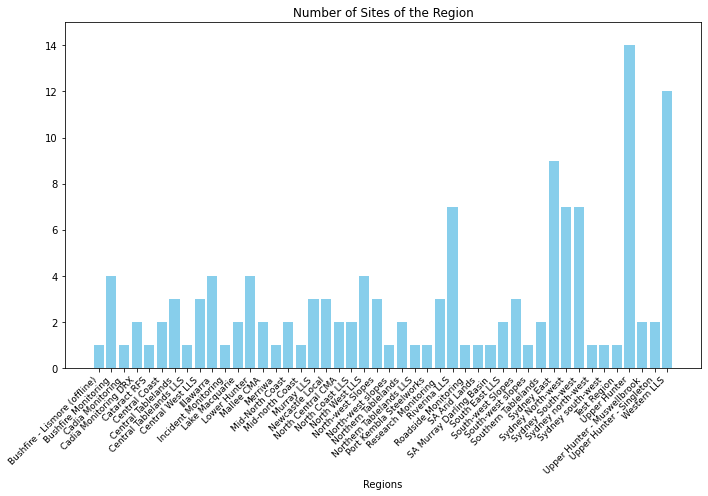

In [25]:
"""
Site_Fig1: [Bar Plot] displays the number of sites for each region 
x-axis: Regions
y-axis: Number of sites for the region 
Key Finding: 
"""
# Count the number of site_ids for each region
wrk_site = site_df.copy()

# Plotting
plt.figure(figsize=(10,7))
site_count = wrk_site.groupby('Region')['Site_Id'].count().reset_index()
plt.bar(site_count['Region'], site_count['Site_Id'], color='skyblue')
plt.xlabel('Regions')
plt.title('Number of Sites of the Region')
plt.xticks(rotation=45, ha='right', fontsize=9, fontweight='light')
plt.ylim(0,15)  # Setting limit from 1 to 15 for better visualization
plt.tight_layout()
plt.show()

### Observation Dataframe 

/var/folders/k4/cwybqqwd4798fy6y2t6n020h0000gn/T/ipykernel_95456/380543429.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(wrk_obs['Year'].unique())


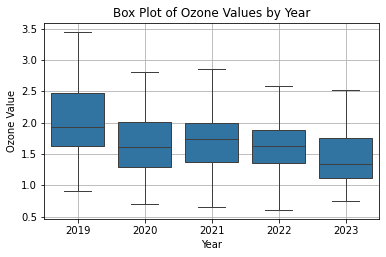

In [30]:
"""
Obs_Fig1: [Box Plot] dispalys ozone value distribution for each year
x-axis: year [2019, 2020, 2021, 2022, 2023]
y-axis: min, median, max, 25/75 quartile, outliers 
"""

# Extract year from 'Date' column and create a new column for it
wrk_obs = obs_df.copy()
wrk_obs = wrk_obs[wrk_obs['Value'] != -999] # filter out empty value
wrk_obs['Year'] = wrk_obs['Date'].dt.year

fig, ax = plt.subplots(figsize=(6, 3.6))

# plot the box plot for each year
sns.boxplot(data=wrk_obs, x='Year', y='Value')
# label x/y-axis and title
ax.set_xlabel('Year')
ax.set_ylabel('Ozone Value')
ax.set_title('Box Plot of Ozone Values by Year')
ax.set_xticklabels(wrk_obs['Year'].unique())
plt.suptitle("")
ax.grid(True)

plt.show()

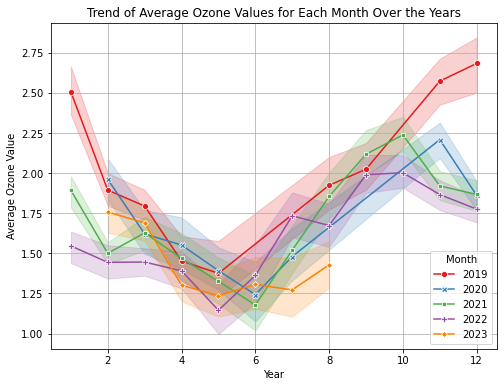

In [31]:
"""
Obs_Fig2: [Line Chart] displays the average ozone values of each month for the past 5 years. 
x-axis: month [1, 2, ..., 12]
y-axis: avg ozone value for the month
"""

plt.figure(figsize=(8, 6))  # Adjust the figsize as needed
wrk_obs = obs_df.copy()
wrk_obs = wrk_obs[wrk_obs['Value'] != -999] # filter out empty value
wrk_obs['Year'] = obs_df['Date'].dt.year
wrk_obs['Month'] = obs_df['Date'].dt.month
sns.lineplot(data=wrk_obs, x='Month', y='Value', hue='Year', style="Year", markers=True, dashes=False, palette=sns.color_palette("Set1", 5))

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Average Ozone Value')
plt.title('Trend of Average Ozone Values for Each Month Over the Years')

# Add legend to show different lines for each month
plt.legend(title='Month')

# Show plot
plt.grid(True)
plt.show()


/var/folders/k4/cwybqqwd4798fy6y2t6n020h0000gn/T/ipykernel_95456/3958032601.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(wrk_obs['SiteName'].unique(), rotation=20, ha='right')


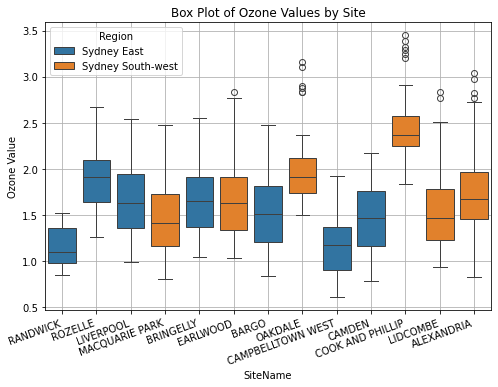

In [32]:
"""
Obs_Fig3: [Box Plot] displays the average ozone values for each site  
x-axis: SiteName ['AAA', 'BBB', ..., 'ZZZ']
y-axis: min, max, median, outliers, quartiles of OZONE value 
"""
wrk_obs = obs_df.copy()
wrk_obs = wrk_obs[wrk_obs['Value'] != -999] # filter out empty value
wrk_obs = pd.merge(wrk_obs, site_df, on='Site_Id', how='left')
fig, ax = plt.subplots(figsize=(8, 5.3))

sns.boxplot(data=wrk_obs, x='Site_Id', y='Value', hue='Region')

# label x/y-axis and title
ax.set_xlabel('SiteName')
ax.set_ylabel('Ozone Value')
ax.set_title('Box Plot of Ozone Values by Site')
ax.tick_params(axis='both', which='minor', labelsize=6)
ax.set_xticklabels(wrk_obs['SiteName'].unique(), rotation=20, ha='right')
ax.grid(True)

plt.show()


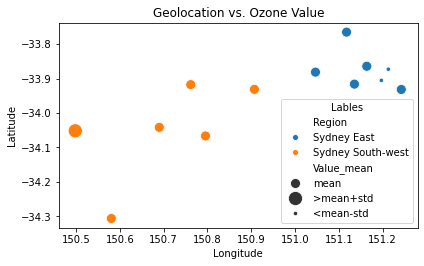

In [34]:
"""
Obs_Fig4: [Scatter Plot] displays the geo-location of each site 
x-axis: Longitude 
y-axis: Latitude
color: Region 
"""
wrk_obs = obs_df.copy()
wrk_obs = wrk_obs[wrk_obs['Value'] != -999] # filter out empty value
wrk_obs = pd.merge(wrk_obs, site_df, on='Site_Id', how='left')
mean_ozone_per_site = wrk_obs.groupby('Site_Id')['Value'].mean().reset_index()
wrk_obs = pd.merge(wrk_obs, mean_ozone_per_site, on='Site_Id', suffixes=('', '_mean'))
labels = ['<mean-std', 'mean', '>mean+std'] 
std = wrk_obs.Value_mean.describe()['std']
mean = wrk_obs.Value_mean.describe()['mean']
condition = [(wrk_obs['Value_mean'] < mean - std), 
             ((mean-std < wrk_obs['Value_mean']) & (wrk_obs['Value_mean'] < mean+std)), 
             (wrk_obs['Value_mean'] > mean+std)]
wrk_obs['Value_mean'] = np.select(condition, labels, default=wrk_obs['Value_mean'])

plt.figure(figsize=(6, 3.8))
cust_size = {'<mean-std':20, 'mean':100, '>mean+std': 200}
sns.scatterplot(data=wrk_obs, x='Longitude', y='Latitude', hue='Region', size='Value_mean', sizes=cust_size)

plt.title('Geolocation vs. Ozone Value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Lables')
plt.tight_layout()
plt.show()